# Preparation
## Importing necessary libraries and dataset

In [1]:
# Stops the verbose form PyMC
import logging
logger = logging.getLogger("pymc")
logger.propagate = False
logger.setLevel(logging.ERROR)

from base_functions import *
test_script()

Script containing strategy evaluation functions were imported successfully!


In [5]:
# Imports df
try:
    df = pd.read_csv('odds_df.csv')
except:
    csv_url = "https://www.football-data.co.uk/new/BRA.csv"
    df = pd.read_csv(csv_url)


# Isolates the period under analysis and filter columns
df = df[(df['Season'] >= 2019) & (df['Season'] <= 2024)]
columns_to_keep = ['Season', 'Home', 'Away', 'Res', 'AvgCH', 'AvgCD', 'AvgCA','MaxCH', 'MaxCD', 'MaxCA', 'PSCH', 'PSCD', 'PSCA']
df = df[columns_to_keep]
df = df.dropna(subset=columns_to_keep)

df.head()

,Season,Home,Away,Res,AvgCH,AvgCD,AvgCA,MaxCH,MaxCD,MaxCA,PSCH,PSCD,PSCA
2660,2019,Sao Paulo,Botafogo RJ,H,1.74,3.37,5.14,1.81,3.60,5.80,1.78,3.39,5.61
2661,2019,Atletico-MG,Avai,H,1.53,3.90,6.34,1.58,4.09,7.00,1.56,4.09,6.46
2662,2019,Chapecoense-SC,Internacional,H,2.94,2.94,2.59,3.15,3.20,2.71,3.02,3.03,2.71
2663,2019,Flamengo RJ,Cruzeiro,H,2.21,3.12,3.40,2.32,3.40,3.57,2.32,3.20,3.47
2664,2019,Gremio,Santos,A,1.71,3.41,5.31,1.83,3.60,5.94,1.71,3.58,5.78


In [2]:
def analyze_odds(df):
    """
    Analyzes odds in the dataset to determine the favorite outcome (lowest odds) and underdog (highest odds)
    according to the market consensus.

    Parameters:
        df (pd.DataFrame): Input dataframe with columns 'AvgCH', 'AvgCD', 'AvgCA'.

    Returns:
        pd.DataFrame: A new dataframe with 'Fav' and 'Dog' columns added,
                      containing the favorite and underdog outcomes for each row.
    """
    # Define a helper function to determine the favorite and underdog
    def find_fav_dog(row):
        odds = {'H': row['AvgCH'], 'D': row['AvgCD'], 'A': row['AvgCA']}
        fav = min(odds, key=odds.get)  # Outcome with the lowest odds
        dog = max(odds, key=odds.get)  # Outcome with the highest odds
        return pd.Series({'Fav': fav, 'Dog': dog})

    # Apply the helper function row-wise and create 'Fav' and 'Dog' listings
    results = df.apply(find_fav_dog, axis=1)
    return results

In [7]:
crowd_judgments = analyze_odds(df)
df = df.assign(Fav=crowd_judgments['Fav'], Dog=crowd_judgments['Dog'])

# Exploratory data analysis
1. How often does the crowd estimate each result to happen vs. how often does each result happen?
2. Over the years, was there a major change on how much each result was expected? What about a change in how much each result happened?

In [5]:
def measure_crowd_preferences(df):
  seasons = df['Season'].unique()

  for season in seasons:
    season_df = df[df['Season'] == season]

    home_preference = round(sum(season_df['Fav'] == 'H')/len(season_df), 2)
    draw_preference = round(sum(season_df['Fav'] == 'D')/len(season_df), 2)
    away_preference = round(sum(season_df['Fav'] == 'A')/len(season_df), 2)

    home_concretization = round(sum(season_df['Res'] == 'H')/len(season_df), 2)
    draw_concretization = round(sum(season_df['Res'] == 'D')/len(season_df), 2)
    away_concretization = round(sum(season_df['Res'] == 'A')/len(season_df), 2)

    print(f'Season: {season}')
    print(f'Prefence for HOME victory vs. how often it actually happened: {home_preference}% vs. {home_concretization}%')
    print(f'Prefence for DRAW vs. how often it actually happened: {draw_preference}% vs. {draw_concretization}%')
    print(f'Prefence for AWAY victory vs. how often it actually happened: {away_preference}% vs. {away_concretization}%\n')

measure_crowd_preferences(df)

Season: 2019
Prefence for HOME victory vs. how often it actually happened: 0.76% vs. 0.48%
Prefence for DRAW vs. how often it actually happened: 0.0% vs. 0.26%
Prefence for AWAY victory vs. how often it actually happened: 0.24% vs. 0.26%

Season: 2020
Prefence for HOME victory vs. how often it actually happened: 0.7% vs. 0.45%
Prefence for DRAW vs. how often it actually happened: 0.0% vs. 0.28%
Prefence for AWAY victory vs. how often it actually happened: 0.3% vs. 0.27%

Season: 2021
Prefence for HOME victory vs. how often it actually happened: 0.74% vs. 0.46%
Prefence for DRAW vs. how often it actually happened: 0.0% vs. 0.3%
Prefence for AWAY victory vs. how often it actually happened: 0.26% vs. 0.24%

Season: 2022
Prefence for HOME victory vs. how often it actually happened: 0.76% vs. 0.44%
Prefence for DRAW vs. how often it actually happened: 0.0% vs. 0.28%
Prefence for AWAY victory vs. how often it actually happened: 0.24% vs. 0.27%

Season: 2023
Prefence for HOME victory vs. how 

Conclusions:
1. Home teams in fact win more than away teams. There is plenty on the literature talking about the home team advantage, and we also see it on the data: on average, between 2019-2024, each season saw 46.16% of their matches ending up in a victory of the home team, compared to 27.5% in draws and 26.39% in away victories.
2. The crowd tends to overestimate the chance of the home team winning while absolutely ignoring that draws can happen. Even though around 28% of matches end up in a draw, the crowd never considers this outcome to be the most likely. This means that, if we are following the crowd, by default we will get at least 28% of our bets wrong.

In the plot below, positive bars indicate overconfidence: the crowd thought a certain type of outcome was more likely than it actually was. Negative bars indicate underconfidence: the outcome happened more than the crowd predicted.

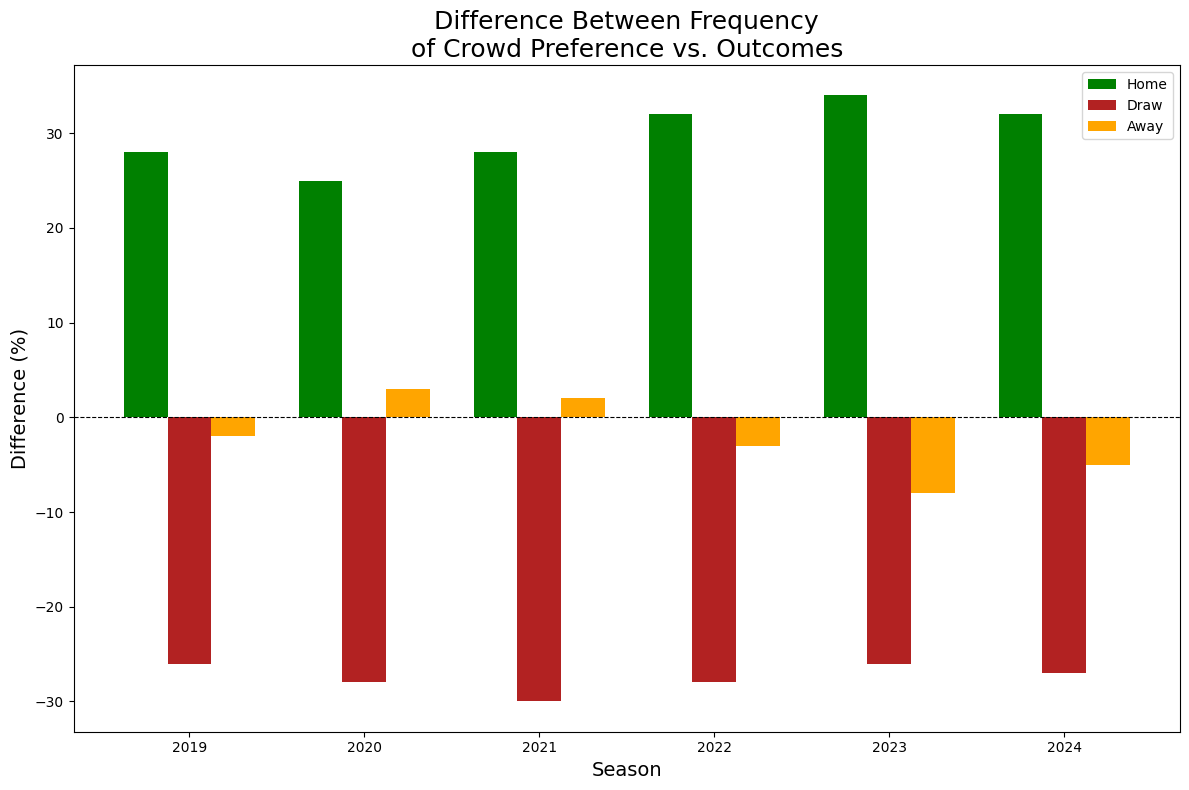

In [9]:
def plot_crowd_preferences(df):
    # Extract unique seasons
    seasons = sorted(df['Season'].unique())
    results = []

    # Calculate differences for each season
    for season in seasons:
        season_df = df[df['Season'] == season]

        home_preference = round(sum(season_df['Fav'] == 'H') / len(season_df), 2)
        draw_preference = round(sum(season_df['Fav'] == 'D') / len(season_df), 2)
        away_preference = round(sum(season_df['Fav'] == 'A') / len(season_df), 2)

        home_concretization = round(sum(season_df['Res'] == 'H') / len(season_df), 2)
        draw_concretization = round(sum(season_df['Res'] == 'D') / len(season_df), 2)
        away_concretization = round(sum(season_df['Res'] == 'A') / len(season_df), 2)

        # Calculate the differences
        home_diff = (home_preference - home_concretization)*100
        draw_diff = (draw_preference - draw_concretization)*100
        away_diff = (away_preference - away_concretization)*100

        results.append((home_diff, draw_diff, away_diff))

    # Plot the results
    bar_width = 0.25
    x_indices = np.arange(len(seasons))

    # Split the results into separate lists
    home_diffs, draw_diffs, away_diffs = zip(*results)

    # Create the bar plot
    plt.figure(figsize=(12, 8))
    plt.bar(x_indices - bar_width, home_diffs, bar_width, label="Home", color="green")
    plt.bar(x_indices, draw_diffs, bar_width, label="Draw", color="firebrick")
    plt.bar(x_indices + bar_width, away_diffs, bar_width, label="Away", color="orange")

    # Customize the plot
    plt.xticks(x_indices, seasons)
    plt.xlabel("Season", fontsize = 14)
    plt.ylabel("Difference (%)", fontsize = 14)
    plt.title("Difference Between Frequency\nof Crowd Preference vs. Outcomes", fontsize = 18)
    plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
    plt.legend()
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_crowd_preferences(df)


# What happens if we always bet on the favorite?

Assumptions:
1. Given we need to wait for the market consensus, we don't have much space to look for ideal odds. This is simulated by using the average market odds
2. Bookmaker's vig is evenly spread across outcomes, allowing us to calculate the odds implied probabilities through the multiplication method
3. We assume the crowd's predictive skills do not get better or worse over time, which is corroborated by the historical data. Therefore, we employ complete pooling to estimate sharpness

In [15]:
# CORRECTED VERSION
def bet_wisdom_of_crowds(df, seasons, category, plot_title):
  """
    Simulates the process of betting on the favorite outcome across many seasons

    Parameters:
        df (DataFrame): A Pandas DataFrame containing match data. It is expected to have columns
        seasons (list): A list of unique season identifiers (e.g., years or labels) to iterate over.
        category (str): Whether we are betting on Favorites ('Fav') or Underdogs ('Dog')
        plot_title (str): Title for the final plot of alternative profits

  """

  # Initializes lists to store results for each season
  betting_log = pd.DataFrame(columns=['Season', 'Target', 'Result', 'Successful bet', 'Profit/Loss', 'Odds locked', 'Pinnacle OIP'])

  for season in seasons:
    # Filter the DataFrame for the current season
    season_df = df[df['Season'] == season]

    # Iterate through each match in the season
    for index, row in season_df.iterrows():

      target = row[category] # If we are evaluating Fav, for example, it checks if the Favorite in this row is H, D, or A
      result = row['Res']
      successful_bet = 1 if target == result else 0
      odds_locked = row[f'AvgC{target}']
      profit_loss = (odds_locked - 1) if successful_bet else -1
      pinnacle_odds_implied_probability = (1/row[f'PSC{target}']) / ( (1/row['PSCH']) + (1/row['PSCD']) + (1/row['PSCA']) )


      # Populates betting log with info specific to each match
      betting_log.loc[len(betting_log)] = {'Season': season,
                                           'Target': target,
                                           'Result': result,
                                           'Successful bet': successful_bet,
                                           'Profit/Loss': profit_loss,
                                           'Odds locked': odds_locked,
                                           'Pinnacle OIP': pinnacle_odds_implied_probability}

  # Summarizes results
  posterior_samples = summarize_results(seasons, betting_log, plot_title)
  return posterior_samples

Season-specific results
╒══════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│  Season  │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│   2019   │      380      │        204        │ [0.486, 0.586] │       0.54       │  0.53  │    -2.09     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2020   │      380      │        190        │ [0.448, 0.549] │       0.5        │  0.5   │     -2.9     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2021   │      380      │        193        │ [0.457, 0.558] │       0.51       │  0.5   │     0.23     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼───────────

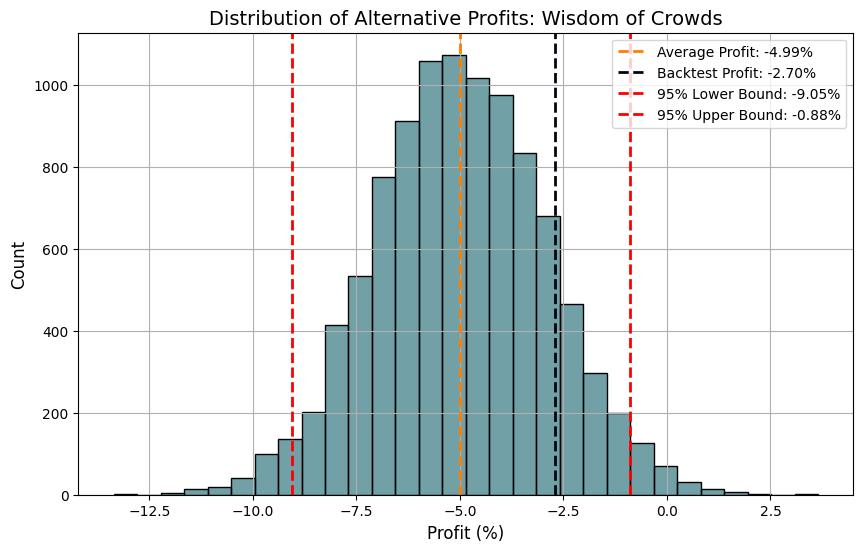


Summary of random effect analysis
  Average profit over simulations: -4.99%
  95% interval of profit: [-9.05%, -0.88%]
  Probability of ending better off than in the backtest: 13.41%
  Probability of ending with a loss: 99.19%


In [16]:
seasons = [2019, 2020, 2021, 2022, 2023, 2024]
posterior_wisdom_of_crowds = bet_wisdom_of_crowds(df, seasons, 'Fav', "Wisdom of Crowds")

Season-specific results
╒══════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│  Season  │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│   2019   │      380      │        69         │ [0.146, 0.223] │       0.18       │  0.23  │    -21.29    │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2020   │      380      │        81         │ [0.175, 0.257] │       0.22       │  0.26  │    -10.38    │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2021   │      380      │        71         │ [0.149, 0.227] │       0.19       │  0.25  │    -22.11    │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼───────────

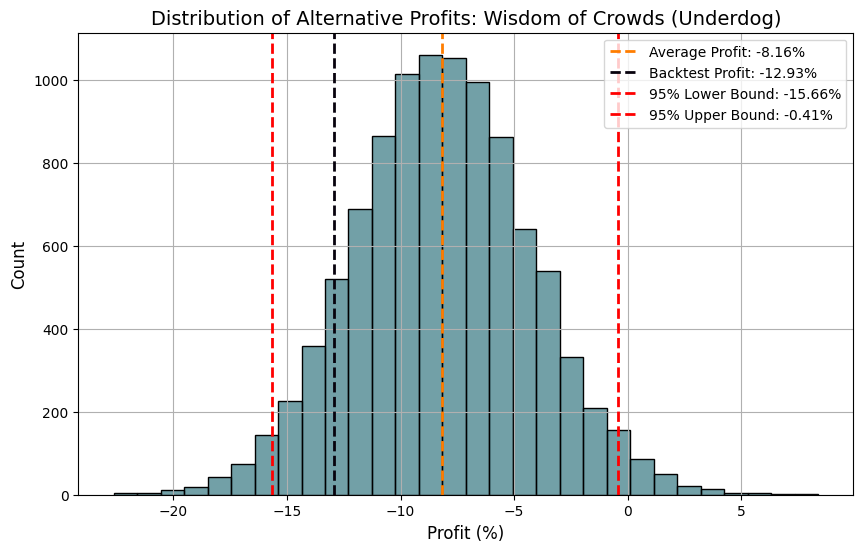


Summary of random effect analysis
  Average profit over simulations: -8.16%
  95% interval of profit: [-15.66%, -0.41%]
  Probability of ending better off than in the backtest: 89.43%
  Probability of ending with a loss: 98.04%


In [17]:
seasons = [2019, 2020, 2021, 2022, 2023, 2024]
_= bet_wisdom_of_crowds(df, seasons, 'Dog', "Wisdom of Crowds (Underdog)")

# Over time, does the accuracy of the crowd get better?

Not, it does not. Although one could argue that, as the season goes by, the crowd becomes better at preciting which team is going to win, the data does not support that hypothesis. Instead, the crowd's ability to predict outcomes resembles a random walk, fluctuating around a range of values without any particular pattern.

In [19]:
def measure_wisdom_crowds(df, seasons):
    # Initialize the results dictionary
    results_dict = {}

    # Define buckets with round ranges
    bucket_ranges = [
        (1, 5), (6, 10), (11, 15), (16, 20),
        (21, 25), (26, 30), (31, 34), (35, 38)
    ]

    for season in seasons:
        # Filter the dataframe for the current season
        season_df = df[df['Season'] == season].copy()

        # Calculate the Round based on the index and matches per round
        season_df['Round'] = (season_df.index % 380) // 10 + 1

        # Assign buckets based on the round number
        def assign_bucket(round_num):
            for i, (start, end) in enumerate(bucket_ranges):
                if start <= round_num <= end:
                    return i + 1  # Bucket index starts at 1
            return None

        season_df['Bucket'] = season_df['Round'].apply(assign_bucket)

        # Ensure results_dict has an entry for this season
        results_dict[season] = {}

        # Process each bucket
        buckets = season_df['Bucket'].unique()
        for bucket in buckets:
            bucket_df = season_df[season_df['Bucket'] == bucket]

            bets_placed = len(bucket_df)
            correct_bets = sum(bucket_df['Fav'] == bucket_df['Res'])

            # print(f'Season: {season}, bucket: {bucket}, {bets_placed}, {correct_bets}')

            # Calculate and store accuracy
            if bets_placed > 0:
                results_dict[season][bucket] = correct_bets / bets_placed
            else:
                results_dict[season][bucket] = None

    return results_dict


def display_results(results_dict):
    # Prepare the table headers and data
    buckets = sorted({bucket for year_data in results_dict.values() for bucket in year_data.keys()})
    headers = ["Year"] + [f"Bucket {bucket}" for bucket in buckets] + ["Average"]

    table_data = []

    # Process each year
    for season, bucket_data in results_dict.items():
        row = [season]
        bucket_accuracies = []
        for bucket in buckets:
            accuracy = bucket_data.get(bucket, None)
            if accuracy is not None:
                bucket_accuracies.append(accuracy)
                row.append(f"{accuracy:.2%}")
            else:
                row.append("N/A")

        # Add season average to the row
        season_avg = sum(bucket_accuracies) / len(bucket_accuracies)
        row.append(f"{season_avg:.2%}")

        table_data.append(row)

    # Add the averages row
    averages_row = ["Average"]
    for bucket in buckets:
        bucket_accuracies = [
            bucket_data.get(bucket, None)
            for bucket_data in results_dict.values()
            if bucket in bucket_data
        ]
        bucket_accuracies = [acc for acc in bucket_accuracies if acc is not None]
        if bucket_accuracies:
            bucket_avg = sum(bucket_accuracies) / len(bucket_accuracies)
            averages_row.append(f"{bucket_avg:.2%}")
        else:
            averages_row.append("N/A")

    # Overall average for all buckets
    all_accuracies = [
        acc
        for bucket_data in results_dict.values()
        for acc in bucket_data.values()
        if acc is not None
    ]
    if all_accuracies:
        overall_avg = sum(all_accuracies) / len(all_accuracies)
        averages_row.append(f"{overall_avg:.2%}")
    else:
        averages_row.append("N/A")

    table_data.append(averages_row)

    # Print the table
    print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))



The plot below shows how the accuracy of the crowd behaves over the course of each season. The greater the bucket, the more rounds have gone by. The entry in the intersection of "Bucket 1" and "2019", for example, represents how often the crowd predicted the correct result among all matches of the first six rounds in the 2019 season.

In [20]:
seasons = [2019, 2020, 2021, 2022, 2023, 2024]
wisdom_of_crowds = measure_wisdom_crowds(df, seasons)
display_results(wisdom_of_crowds)

╒═════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤════════════╤═══════════╕
│ Year    │ Bucket 1   │ Bucket 2   │ Bucket 3   │ Bucket 4   │ Bucket 5   │ Bucket 6   │ Bucket 7   │ Bucket 8   │ Average   │
╞═════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪════════════╪═══════════╡
│ 2019    │ 58.00%     │ 64.00%     │ 48.00%     │ 50.00%     │ 54.00%     │ 54.00%     │ 45.00%     │ 55.00%     │ 53.50%    │
├─────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼───────────┤
│ 2020    │ 44.00%     │ 52.00%     │ 46.00%     │ 46.00%     │ 54.00%     │ 52.00%     │ 55.00%     │ 52.50%     │ 50.19%    │
├─────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼────────────┼───────────┤
│ 2021    │ 42.00%     │ 44.00%     │ 50.00%     │ 44.00%     │ 40.00%     │ 58.00%     │ 67.50%     │ 6

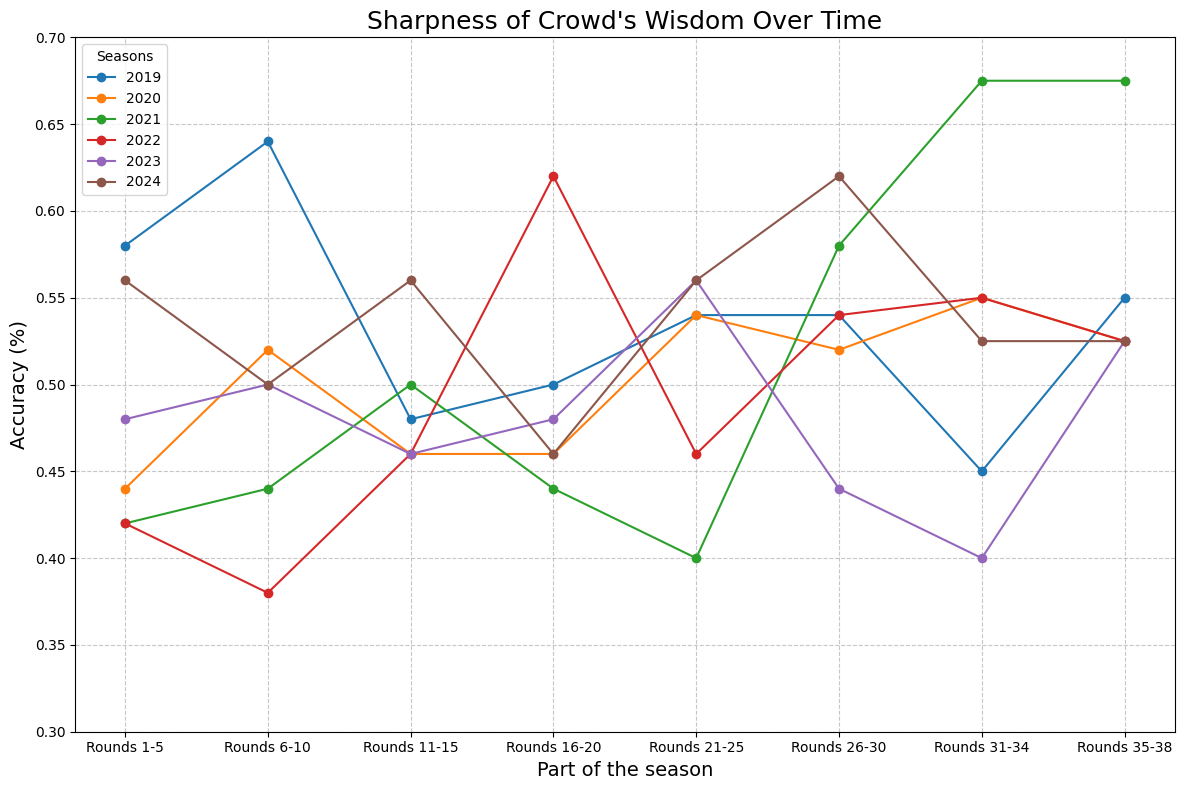

In [21]:
def plot_results(results_dict):

    # Bucket names
    bucket_ranges = [
        "Rounds 1-5", "Rounds 6-10", "Rounds 11-15",
        "Rounds 16-20", "Rounds 21-25", "Rounds 26-30",
        "Rounds 31-34", "Rounds 35-38"]

    buckets = range(1, len(bucket_ranges) + 1)

    # Prepare data for plotting
    seasons = sorted(results_dict.keys())
    season_accuracies = {season: [] for season in seasons}

    for season in seasons:
        year_data = results_dict[season]
        for bucket in buckets:
            accuracy = year_data.get(bucket, None)
            if accuracy is not None:
                season_accuracies[season].append(accuracy)
            else:
                season_accuracies[season].append(None)

    # Plot each season's accuracy over buckets
    plt.figure(figsize=(12, 8))
    for season, accuracies in season_accuracies.items():
        plt.plot(
            buckets,
            accuracies,
            marker='o',
            label=f"{season}"
        )

    # Customize the chart
    plt.title("Sharpness of Crowd's Wisdom Over Time", fontsize=18)
    plt.xlabel("Part of the season", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.ylim(0.3, 0.7)  # Accuracy is between 0 and 1
    plt.xticks(buckets, bucket_ranges)  # Replace bucket numbers with round ranges
    plt.legend(title="Seasons", loc="best")
    plt.grid(True, linestyle="--", alpha=0.7)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Plot results
plot_results(wisdom_of_crowds)


# Following the crowd (with constraints as to where the team is playing)

We test a variant of the strategy where we also constrain bets based on where a team is playing. If before we were evaluating what happens when we always bet on the favorite, we now test a slightly different approach. For example, what happens when we bet on the favorite team when the favorite team is playing at home?

The conclusions are as follows:

1. In terms of sharpness, we can enhance the quality of our bets by betting only on home favorites, rather than all favorites. This increased our AROB and sharpness mean in five out of the six years analyzed. The profit readings also changed slightly, with the bets on home favorites having higher profit (or smaller losses) in four out of the six seasons.

2. An interesting thing to notice is that, despite having worse AROB and sharpness mean in most seasons (five out of the six), betting on away favorites actually led to better financial outcomes. The average loss over the six years was -0.68%, compared to -2.04% of betting on home favorites. The reason, however, is related to the frequencies of bets: given that visiting favorites are rare, less bets were placed, less money was lost, and a particularly successful year (which yielded a profit of 4.11%) decreases the average loss. This is not explorabl as a strategy.

In [28]:
def bet_constrained_wisdom_of_crowds(df, seasons, category, placement, plot_title):
  """
    Simulates the process of betting on the favorite outcome across many seasons

    Parameters:
        df (DataFrame): A Pandas DataFrame containing match data. It is expected to have columns
        seasons (list): A list of unique season identifiers (e.g., years or labels) to iterate over.
        category (str): Whether we are betting on Favorites ('Fav') or Underdogs ('Dog')
        placement (str): Whether we are betting on Home ('H') or Away ('A') matches
        plot_title (str): Title for the final plot of alternative profits

  """

  # Initializes lists to store results for each season
  betting_log = pd.DataFrame(columns=['Season', 'Target', 'Result', 'Successful bet', 'Profit/Loss', 'Odds locked', 'Pinnacle OIP'])

  for season in seasons:
    # Filter the DataFrame for the current season
    season_df = df[df['Season'] == season]

    # Iterate through each match in the season
    for index, row in season_df.iterrows():

      target = row[category] # If we are evaluating Fav, for example, it checks if the Favorite in this row is H, D, or A
      placement = placement

      if target == placement: # This checks whether the type of team we're looking into (e.g.: Favorite) also happens to be playing where we want it to play (e.g.: Home)
        result = row['Res']
        successful_bet = 1 if target == result else 0
        odds_locked = row[f'AvgC{target}']
        profit_loss = (odds_locked - 1) if successful_bet else -1
        pinnacle_odds_implied_probability = (1/row[f'PSC{target}']) / ( (1/row['PSCH']) + (1/row['PSCD']) + (1/row['PSCA']) )


        # Populates betting log with info specific to each match
        betting_log.loc[len(betting_log)] = {'Season': season,
                                            'Target': target,
                                            'Result': result,
                                            'Successful bet': successful_bet,
                                            'Profit/Loss': profit_loss,
                                            'Odds locked': odds_locked,
                                            'Pinnacle OIP': pinnacle_odds_implied_probability}

  # Summarizes results
  posterior_samples = summarize_results(seasons, betting_log, plot_title)
  return posterior_samples

Season-specific results
╒══════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│  Season  │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│   2019   │      288      │        160        │ [0.496, 0.61]  │       0.56       │  0.57  │    -2.88     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2020   │      265      │        140        │ [0.469, 0.589] │       0.53       │  0.51  │     -0.7     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2021   │      281      │        149        │ [0.469, 0.585] │       0.53       │  0.51  │     2.52     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼───────────

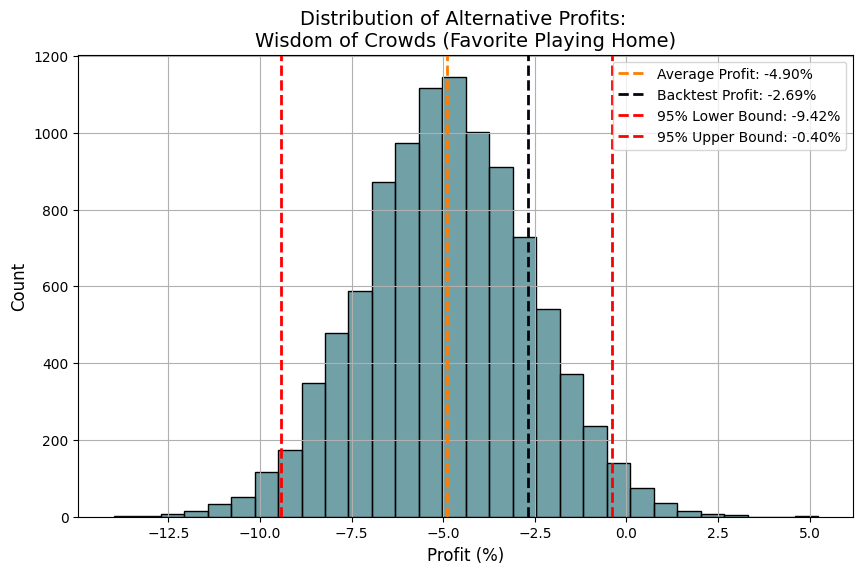


Summary of random effect analysis
  Average profit over simulations: -4.90%
  95% interval of profit: [-9.42%, -0.40%]
  Probability of ending better off than in the backtest: 16.73%
  Probability of ending with a loss: 98.46%


In [24]:
seasons = [2019, 2020, 2021, 2022, 2023, 2024]
_ = bet_constrained_wisdom_of_crowds(df, seasons, 'Fav', 'H', "\nWisdom of Crowds (Favorite Playing Home)")

Season-specific results
╒══════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│  Season  │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│   2019   │      91       │        43         │ [0.377, 0.574] │       0.47       │  0.43  │    -1.27     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2020   │      115      │        50         │ [0.345, 0.525] │       0.44       │  0.46  │    -7.97     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2021   │      98       │        44         │ [0.35, 0.547]  │       0.45       │  0.46  │     -5.3     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼───────────

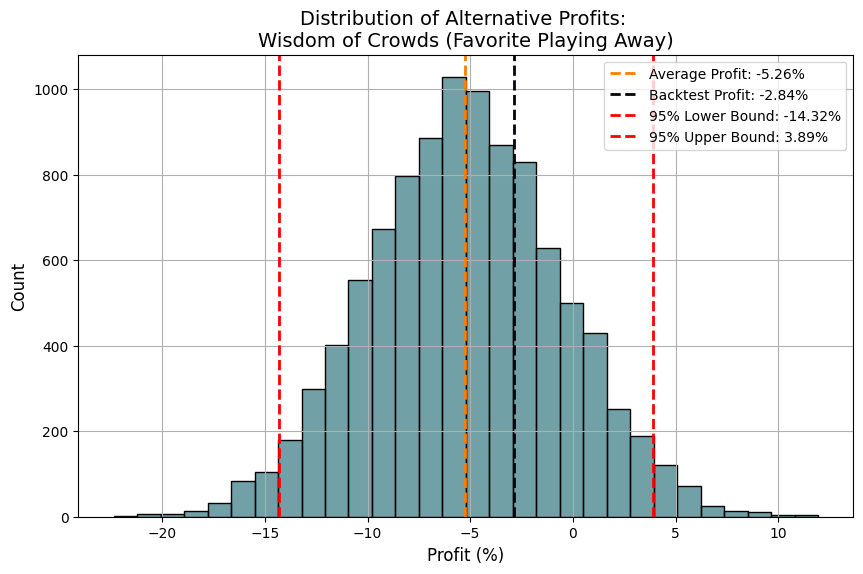


Summary of random effect analysis
  Average profit over simulations: -5.26%
  95% interval of profit: [-14.32%, 3.89%]
  Probability of ending better off than in the backtest: 29.96%
  Probability of ending with a loss: 86.67%


In [25]:
seasons = [2019, 2020, 2021, 2022, 2023, 2024]
_ = bet_constrained_wisdom_of_crowds(df, seasons, 'Fav', 'A', "\nWisdom of Crowds (Favorite Playing Away)")

Season-specific results
╒══════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│  Season  │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│   2019   │      66       │        11         │ [0.088, 0.268] │       0.18       │  0.27  │    -41.11    │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2020   │      84       │        24         │ [0.194, 0.383] │       0.29       │  0.26  │     25.5     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2021   │      74       │        16         │ [0.135, 0.319] │       0.22       │  0.26  │    -15.27    │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼───────────

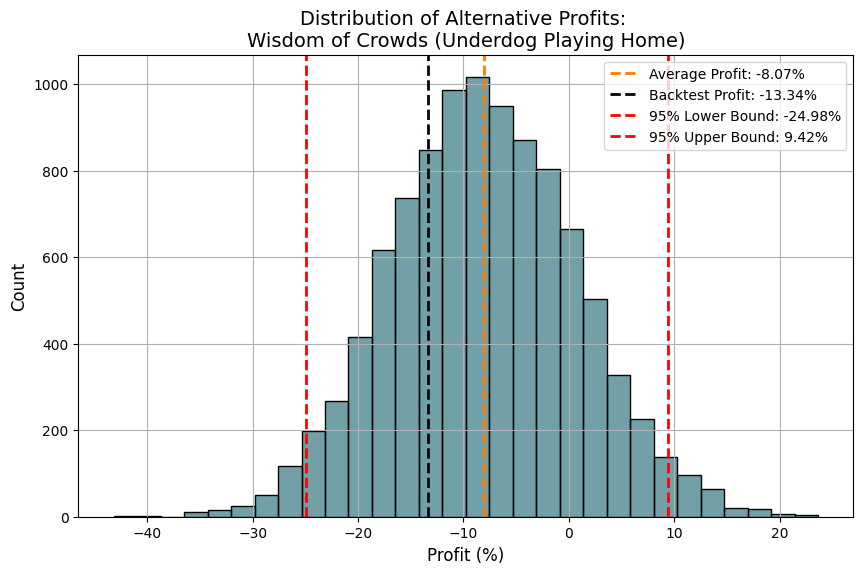


Summary of random effect analysis
  Average profit over simulations: -8.07%
  95% interval of profit: [-24.98%, 9.42%]
  Probability of ending better off than in the backtest: 72.02%
  Probability of ending with a loss: 82.14%


In [26]:
seasons = [2019, 2020, 2021, 2022, 2023, 2024]
_ = bet_constrained_wisdom_of_crowds(df, seasons, 'Dog', 'H', "\nWisdom of Crowds (Underdog Playing Home)")

Season-specific results
╒══════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│  Season  │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│   2019   │      258      │        45         │ [0.129, 0.222] │       0.18       │  0.19  │    -14.57    │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2020   │      227      │        37         │ [0.12, 0.214]  │       0.17       │  0.23  │    -24.5     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2021   │      247      │        42         │ [0.126, 0.219] │       0.17       │  0.22  │    -21.89    │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼───────────

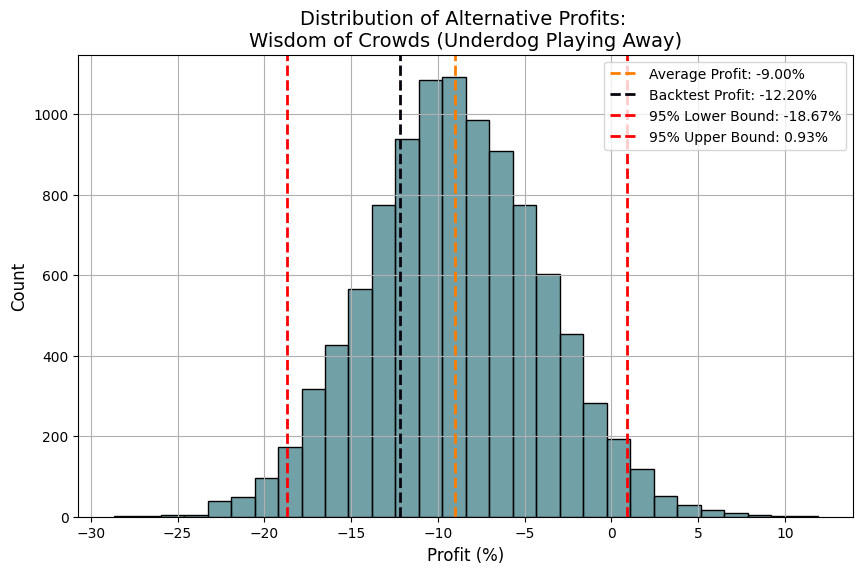


Summary of random effect analysis
  Average profit over simulations: -9.00%
  95% interval of profit: [-18.67%, 0.93%]
  Probability of ending better off than in the backtest: 73.83%
  Probability of ending with a loss: 96.30%


In [27]:
seasons = [2019, 2020, 2021, 2022, 2023, 2024]
_ = bet_constrained_wisdom_of_crowds(df, seasons, 'Dog', 'A', "\nWisdom of Crowds (Underdog Playing Away)")

# Following the crowd but finding better odds

In [29]:
def bet_wisdom_of_crowds(df, seasons, category, plot_title):
  """
    Simulates the process of betting on the favorite outcome across many seasons

    Parameters:
        df (DataFrame): A Pandas DataFrame containing match data. It is expected to have columns
        seasons (list): A list of unique season identifiers (e.g., years or labels) to iterate over.
        category (str): Whether we are betting on Favorites ('Fav') or Underdogs ('Dog')
        plot_title (str): Title for the final plot of alternative profits

  """

  # Initializes lists to store results for each season
  betting_log = pd.DataFrame(columns=['Season', 'Target', 'Result', 'Successful bet', 'Profit/Loss', 'Odds locked', 'Pinnacle OIP'])

  for season in seasons:
    # Filter the DataFrame for the current season
    season_df = df[df['Season'] == season]

    # Iterate through each match in the season
    for index, row in season_df.iterrows():

      target = row[category] # If we are evaluating Fav, for example, it checks if the Favorite in this row is H, D, or A
      result = row['Res']
      successful_bet = 1 if target == result else 0
      odds_locked = row[f'MaxC{target}']
      profit_loss = (odds_locked - 1) if successful_bet else -1
      pinnacle_odds_implied_probability = (1/row[f'PSC{target}']) / ( (1/row['PSCH']) + (1/row['PSCD']) + (1/row['PSCA']) )


      # Populates betting log with info specific to each match
      betting_log.loc[len(betting_log)] = {'Season': season,
                                           'Target': target,
                                           'Result': result,
                                           'Successful bet': successful_bet,
                                           'Profit/Loss': profit_loss,
                                           'Odds locked': odds_locked,
                                           'Pinnacle OIP': pinnacle_odds_implied_probability}

  # Summarizes results
  posterior_samples = summarize_results(seasons, betting_log, plot_title)
  return posterior_samples

Season-specific results
╒══════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│  Season  │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│   2019   │      380      │        204        │ [0.483, 0.584] │       0.54       │  0.51  │     2.64     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2020   │      380      │        190        │ [0.452, 0.552] │       0.5        │  0.47  │     1.82     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2021   │      380      │        193        │ [0.458, 0.558] │       0.51       │  0.48  │     5.47     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼───────────

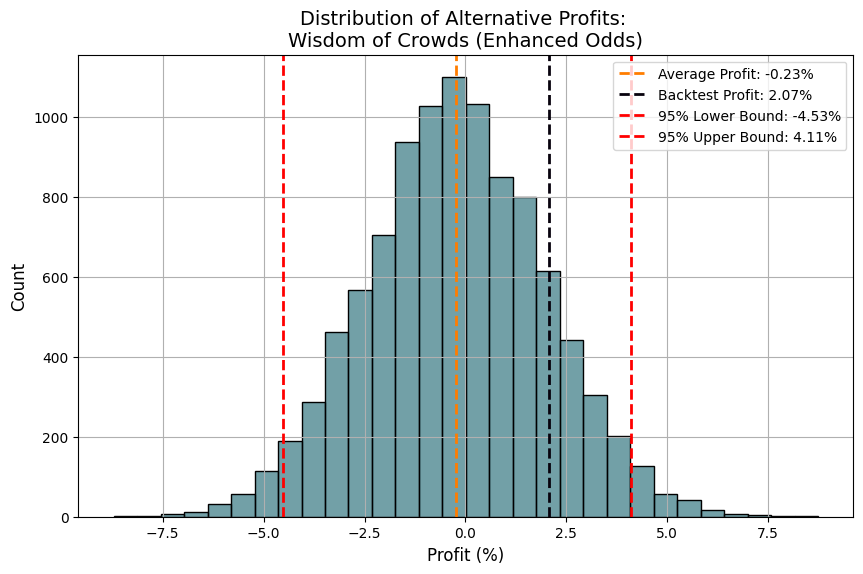


Summary of random effect analysis
  Average profit over simulations: -0.23%
  95% interval of profit: [-4.53%, 4.11%]
  Probability of ending better off than in the backtest: 14.53%
  Probability of ending with a loss: 54.73%


In [30]:
seasons = [2019, 2020, 2021, 2022, 2023, 2024]
_ = bet_wisdom_of_crowds(df, seasons, 'Fav', "\nWisdom of Crowds (Enhanced Odds)")

In [32]:
# Prints posterior samples for future analyses
print(", ".join(map(str, posterior_wisdom_of_crowds)))

0.53935099039285, 0.5085345657962259, 0.5307585594515744, 0.5159353135340521, 0.5272517390584033, 0.5163889293861894, 0.5089076708914475, 0.5172863278817925, 0.5068590757443674, 0.5068590757443674, 0.505524592628971, 0.505524592628971, 0.5047234078079567, 0.5087398423089777, 0.5229758430782755, 0.525357380795162, 0.512759365148096, 0.5197492001415192, 0.5081090282459767, 0.5070611049267137, 0.5044394170163173, 0.5195717228916594, 0.527618740671401, 0.4982440223711004, 0.4928994886334757, 0.4946373336926914, 0.4946373336926914, 0.5017564360677816, 0.4992980181295437, 0.5064367176643354, 0.5064367176643354, 0.5064367176643354, 0.5021468242236875, 0.5127097073348059, 0.5170596712885531, 0.5144791661673854, 0.5107146544857952, 0.5193368852500022, 0.5175528948129549, 0.5204314677898255, 0.5203241744416196, 0.5199014767629282, 0.5120022701567647, 0.4935128819146441, 0.5100663102192089, 0.5204670943330527, 0.5172363714016794, 0.5388377946066355, 0.5259691261531296, 0.5185847093459464, 0.51241